<a href="https://colab.research.google.com/github/louiskhub/happywhale/blob/main/model_trainign_louis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# if you run this local

import os
if os.getcwd()[-10:] != "happywhale":
    os.chdir("..")

In [2]:
# if you run this online (i.e. Colab)

# !git clone https://github.com/louiskhub/happywhale.git
# %cd happywhale

C:\Users\Felix\Desktop\HappyWhale\happywhale\happywhale


fatal: destination path 'happywhale' already exists and is not an empty directory.


In [3]:
#@title Imports, Downloading + cleaning data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorboard as tb
from scipy.interpolate import interp1d

experiment_id = "pTW5SRnfRoCLfdtZBbrDcA"
experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
df = experiment.get_scalars()

def concat_data(df, data_order):
  earlier,later = data_order
  late_indexes = df[df["run"].apply(lambda x: later in x)].index
  earlier_indexes = df[df["run"].apply(lambda x: earlier in x)].index

  max_epoch = df.loc[earlier_indexes,"step"].max() + 1

  df.loc[late_indexes,"step"] += max_epoch
  df.loc[earlier_indexes,"run"]= df.loc[earlier_indexes,"run"].apply(lambda x : x.replace(earlier,later))
  return df

df = df[df["tag"].apply(lambda x : "iter" not  in x)]

df.loc[df["run"].apply(lambda x: "train" in x),"kind_of_training"]="train"
df.loc[df["run"].apply(lambda x: "val" in x),"kind_of_training"]="val"

# replace concate 
data_order_inceptionv3 = ("20220330-111829", "20220330-135917")
df = concat_data(df, data_order_inceptionv3)
data_order_dense = ("211901","084215")
df = concat_data(df, data_order_dense)

df["run"] = df["run"].apply(lambda run:run[:run.find("/")])

val_accs = {}
val_losses = {}
train_losses = {}
train_accs = {}

for model in df["run"].unique():
    val_acc = df[(df["run"]==model) * (df["kind_of_training"]=="val") * (df["tag"]=="epoch_acc")].sort_values("step")["value"].values
    val_accs[model]= list(val_acc)

    val_loss = df[(df["run"]==model) * (df["kind_of_training"]=="val") * (df["tag"]=="epoch_loss")].sort_values("step")["value"].values    
    val_losses[model]= list(val_loss)

    train_loss = df[(df["run"]==model) * (df["kind_of_training"]=="train") * (df["tag"]=="epoch_loss")].sort_values("step")["value"].values    
    train_losses[model]= list(train_loss)

    train_acc = df[(df["run"]==model) * (df["kind_of_training"]=="train") * (df["tag"]=="epoch_acc")].sort_values("step")["value"].values
    train_accs[model]= list(train_acc)

def cut_list(acc,cut_off_vals):
  if len(acc)>=cut_off_vals:
    return acc[:cut_off_vals]
  else:
    return acc + [None for i in range(len(acc),cut_off_vals)]

def smooth(y,cut_off_vals):
  y = y[:cut_off_vals]
  x = np.array(range(1,len(y)+1))
  cubic_interploation_model = interp1d(x, y, kind = "cubic")
  x = np.linspace(x.min(), x.max(), 10*len(x))
  y =cubic_interploation_model(x)
  return x,y

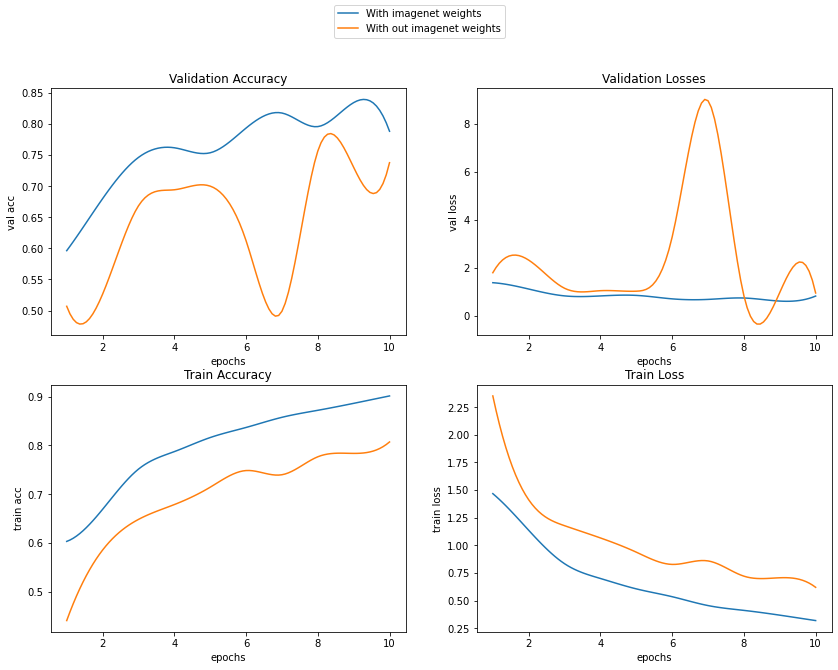

In [9]:
#@title Resnet50 Comparrision with/without imagenet weights
resnet50 = [model for model in df["run"].unique() if 'Resnet50_' in model]
fig, ax = plt.subplots(2,2,figsize=(14, 10))
cut_off_vals = 10

def plot(ax,dict_name):
  for model in resnet50:
    vals = dict_name[model]
    x ,y = smooth(vals,cut_off_vals)
    label = "With out imagenet weights" if "out" in model else "With imagenet weights"
    ax.plot(x,y,label = label)
    ax.set_xlabel("epochs")
   

plot(ax[0,0],val_accs)
ax[0,0].set_ylabel("val acc")
ax[0,0].set_title("Validation Accuracy")

plot(ax[0,1],val_losses)
ax[0,1].set_xlabel("epochs")
ax[0,1].set_ylabel("val loss")
ax[0,1].set_title("Validation Losses")

plot(ax[1,0],train_accs)
ax[1,0].set_xlabel("epochs")
ax[1,0].set_ylabel("train acc")
ax[1,0].set_title("Train Accuracy")

plot(ax[1,1],train_losses)
ax[1,1].set_xlabel("epochs")
ax[1,1].set_ylabel("train loss")
ax[1,1].set_title("Train Loss")

handles, labels = ax[1,1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center')
plt.show()

## Plotting the Performance of the Keras Application Models with Image Net Weights

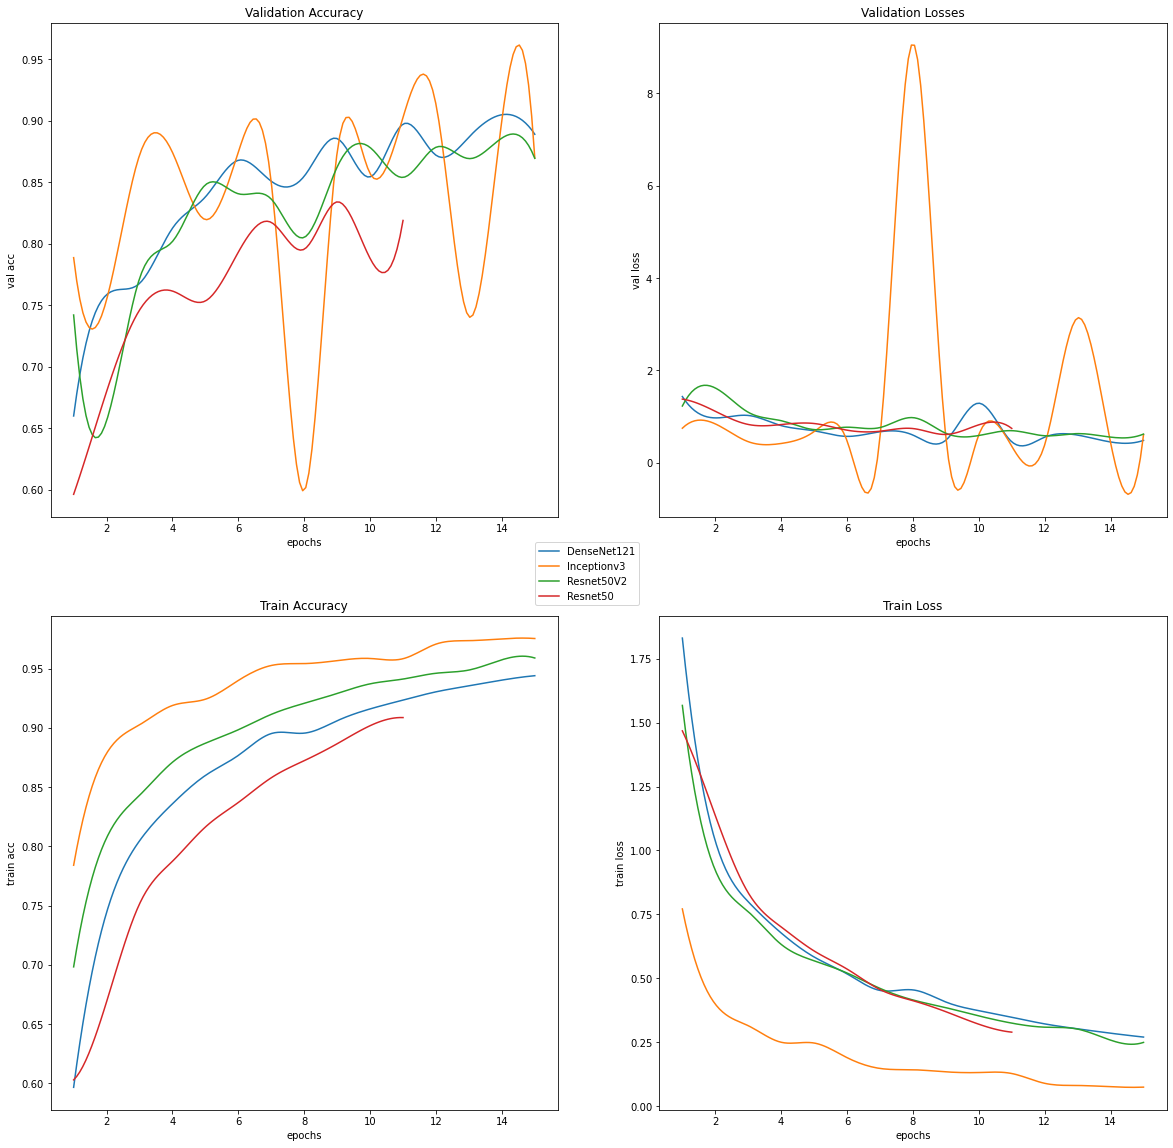

In [5]:
#@title Plotting the Performance of the Keras Application Models with Image Net Weights
image_net_models = [model for model in df["run"].unique() if "image_net" in model]
fig,ax = plt.subplots(2,2,figsize=(20, 20))
cut_off_vals = 15

def plot(ax,dict_name):
  for model in image_net_models:
    vals = dict_name[model]
    x ,y = smooth(vals,cut_off_vals)
    label = (lambda x:x[:x.find("_")])(model)
    ax.plot(x,y,label = label)
    ax.set_xlabel("epochs")

plot(ax[0,0],val_accs)
ax[0,0].set_ylabel("val acc")
ax[0,0].set_title("Validation Accuracy")

plot(ax[0,1],val_losses)
ax[0,1].set_xlabel("epochs")
ax[0,1].set_ylabel("val loss")
ax[0,1].set_title("Validation Losses")

plot(ax[1,0],train_accs)
ax[1,0].set_xlabel("epochs")
ax[1,0].set_ylabel("train acc")
ax[1,0].set_title("Train Accuracy")

plot(ax[1,1],train_losses)
ax[1,1].set_xlabel("epochs")
ax[1,1].set_ylabel("train loss")
ax[1,1].set_title("Train Loss")

handles, labels = ax[1,1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center')

plt.show()

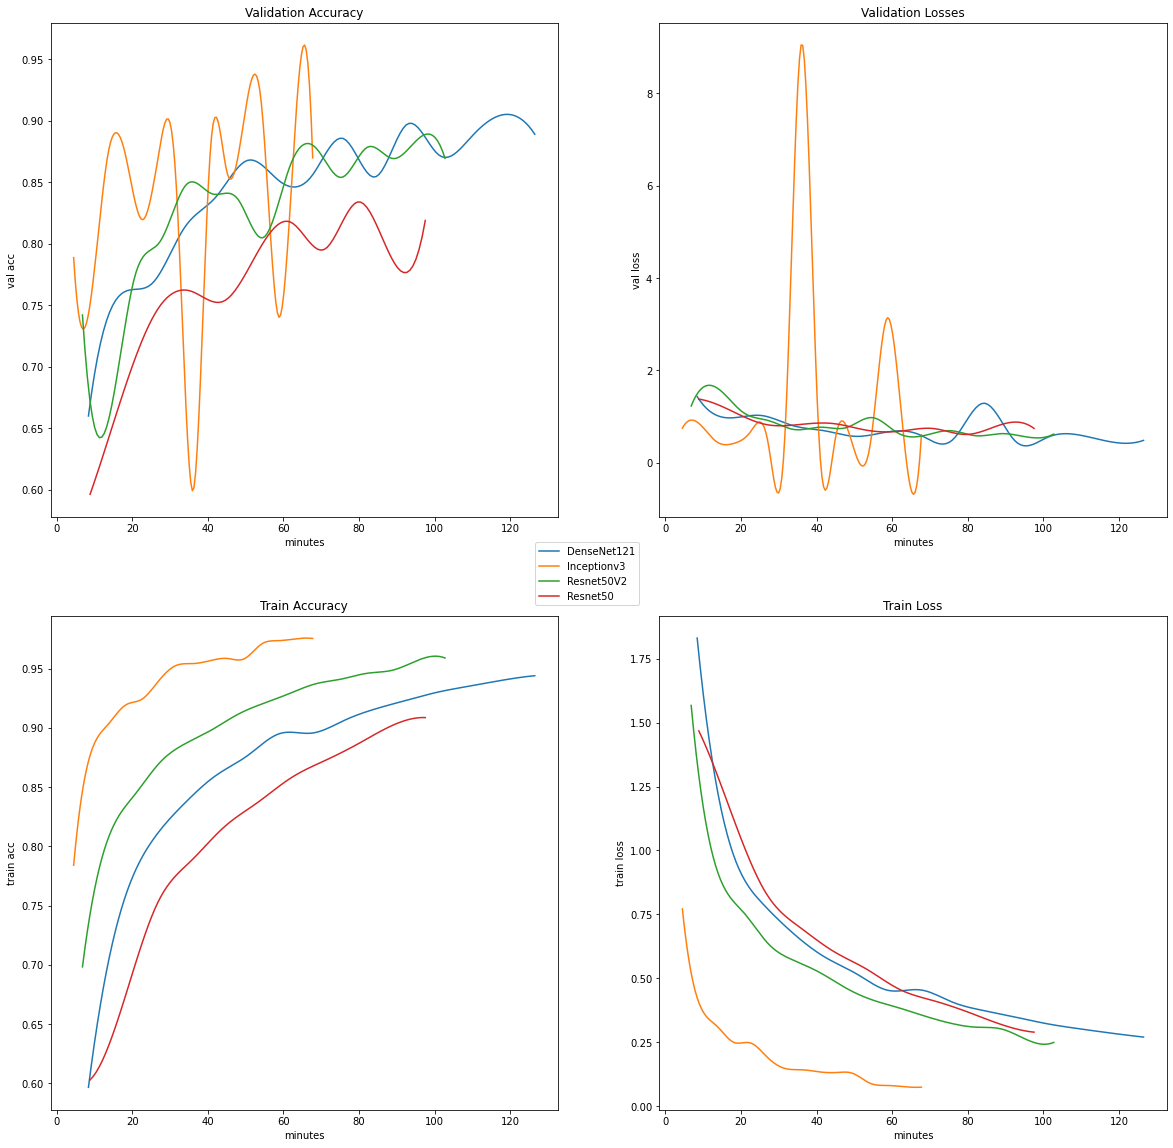

In [6]:
#@title Plotting the Performance of the Keras Application Models with Image Net Weights, normalized by minutes
image_net_models = [model for model in df["run"].unique() if "image_net" in model]
fig,ax = plt.subplots(2,2,figsize=(20, 20))
cut_off_vals = 15

time_per_epoch = {'DenseNet121': 506/60,
 'Inceptionv3': 271/60,
 'Resnet50': 532/60,
 'Resnet50V2': 411/60}

def plot(ax,dict_name):
  for model in image_net_models:
    vals = dict_name[model]
    x ,y = smooth(vals,cut_off_vals)
    x*=time_per_epoch[(lambda x:x[:x.find("_")])(model)]
    label = (lambda x:x[:x.find("_")])(model)
    ax.plot(x,y,label = label)
    ax.set_xlabel("minutes")

plot(ax[0,0],val_accs)
ax[0,0].set_ylabel("val acc")
ax[0,0].set_title("Validation Accuracy")

plot(ax[0,1],val_losses)
ax[0,1].set_ylabel("val loss")
ax[0,1].set_title("Validation Losses")

plot(ax[1,0],train_accs)
ax[1,0].set_ylabel("train acc")
ax[1,0].set_title("Train Accuracy")

plot(ax[1,1],train_losses)
ax[1,1].set_ylabel("train loss")
ax[1,1].set_title("Train Loss")

handles, labels = ax[1,1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center')

plt.show()

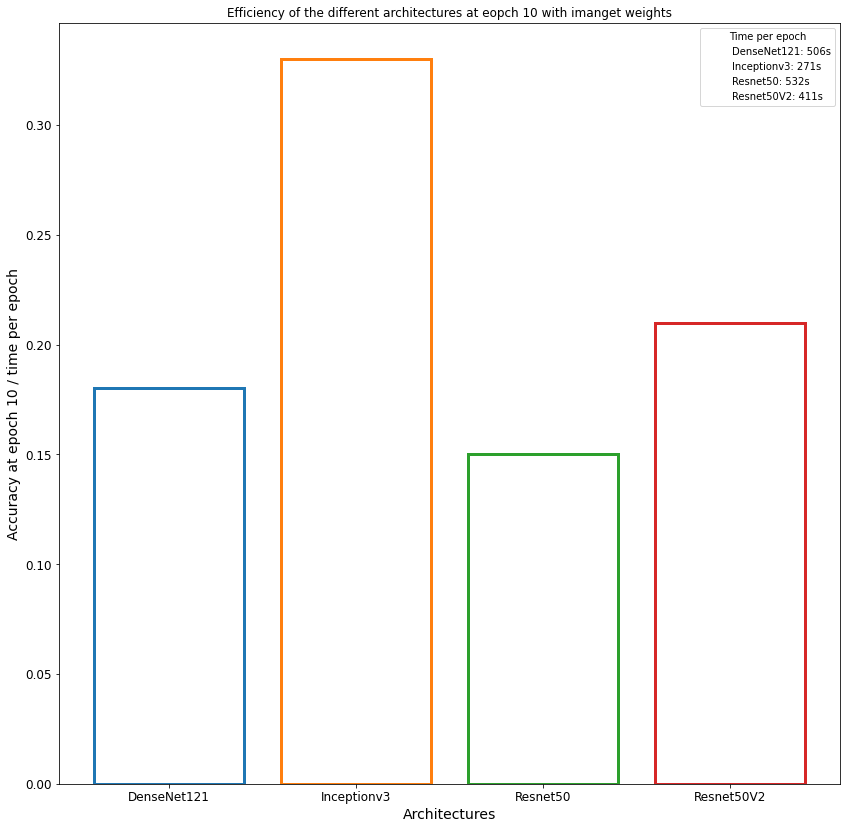

In [7]:
#@title Efficiency of the different architectures at eopch 10 with imanget weights
time_per_epoch = {'DenseNet121': 506,
 'Inceptionv3': 271,
 'Resnet50': 532,
 'Resnet50V2': 411}
val_accs_epoch_10 = {(lambda x:x[:x.find("_")])(model): val_accs[model][10] for model in image_net_models}
acc_time = {model:np.round(val_accs_epoch_10[model]*100/time_per_epoch[model],2) for model in time_per_epoch}

fig = plt.figure(figsize=(14, 14))
colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728']
plt.bar(list(acc_time.keys()),list(acc_time.values()),edgecolor=colors,fill=None, linewidth=3)

for model in time_per_epoch:
  plt.plot([], [], ' ', label=f"{model}: {time_per_epoch[model]}s")


plt.ylabel("Accuracy at epoch 10 / time per epoch",size=14)
plt.yticks(size=12)
plt.xlabel("Architectures",size=14)
plt.xticks(size=12)
plt.title("Efficiency of the different architectures at eopch 10 with imanget weights")
plt.legend( title = "Time per epoch")
plt.show()

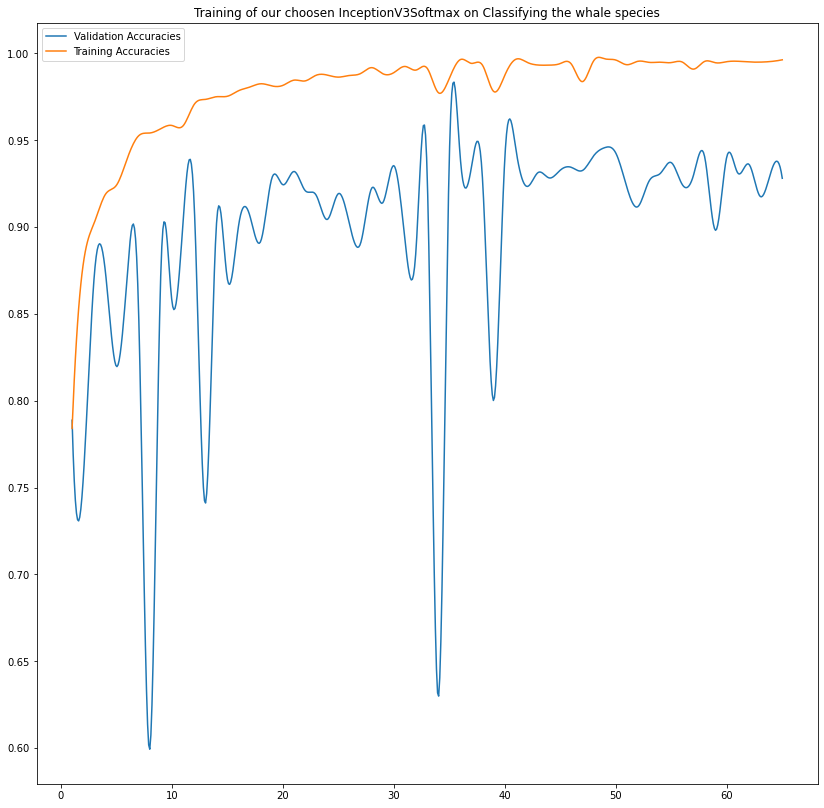

In [8]:
#@title Training of our choosen InceptionV3Softmax on Classifying the whale species
fig = plt.figure(figsize=(14, 14))

vals = val_accs['Inceptionv3_image_net_weights']
x,y = smooth(vals,100)
plt.plot(x,y,label = "Validation Accuracies")

vals = train_accs['Inceptionv3_image_net_weights']
x,y = smooth(vals,100)
plt.plot(x,y,label = "Training Accuracies")
plt.title("Training of our choosen InceptionV3Softmax on Classifying the whale species")
plt.legend()

![picture](https://drive.google.com/uc?id=1o4OSNIoCDaCK1kb0SV9WzUX9-r2xzHn6)
![picture](https://drive.google.com/uc?id=1wpd1TfwoqOsdxnUINT6toUgfDsRRuX8Q)
![picture](https://drive.google.com/uc?id=1Tt_Ry_Vvxl-Pd5fwzL6OTKWsvqXQHVg2)
![picture](https://drive.google.com/uc?id=1i-WjXYRgrwlbViNMB0erCKEREVAJFgit)